# Example 1: using dolomites-apollo to study a linear motor

In [33]:
# import some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# import apollo
from dolomites import apollo

# set font size for figures
mpl.rcParams.update({'font.size': 14})

In [39]:
# we define some motor parameters
data = pd.DataFrame()

# d-q current grid
Id = 10; nd = 51
Iq = 10; nq = 31
i_d = np.linspace(-Id, Id, nd)
i_q = np.linspace(-Iq, Iq, nq)
i_d, i_q = np.meshgrid(i_d, i_q)
i_d = i_d.reshape(nd * nq)
i_q = i_q.reshape(nd * nq)

# the motor (constant) parameters
Ld = 2e-3
Lq = 30e-3
Ldq = 0.8e-3
#Ldq = 0.0e-3
p = 1
Lambda_PM = 0.1

# motor characteristics
lambda_d = Ld * i_d + Ldq * i_q + Lambda_PM
lambda_q = Ldq * i_d + Lq * i_q

# store the values in the dataframe
data['i_d'] = i_d
data['i_q'] = i_q
data['lambda_d'] = lambda_d
data['lambda_q'] = lambda_q
data['torque'] = 0
data['theta_m'] = 0  # assign a default value

mot  = apollo.fm(data)
mot.create_maps(0)  # we have defined only data for theta_m = 0


created maps for theta_m = 0


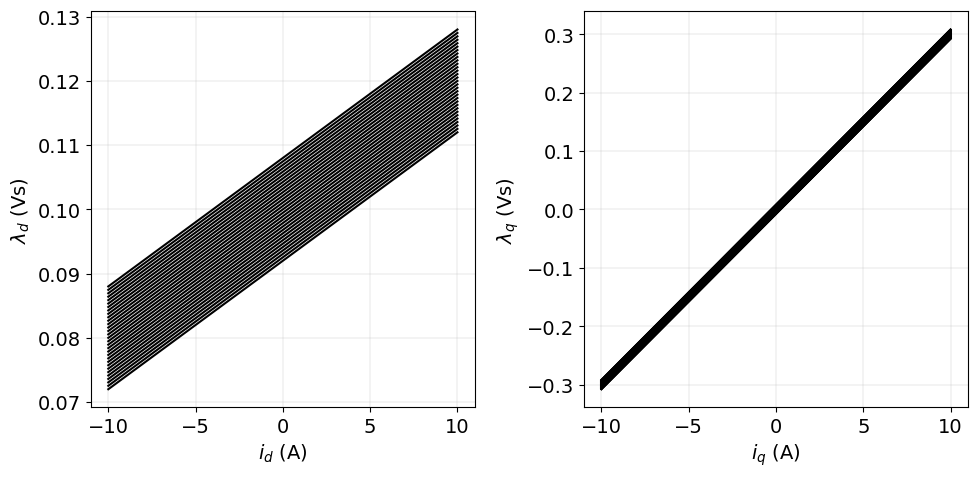

In [40]:
# plot the flux-linkage characteristics (loaded data)
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(mot.i_d, mot.lambda_d, color="black")
plt.xlabel('$i_d$ (A)')
plt.ylabel('$\lambda_d$ (Vs)')
plt.grid(linewidth=0.2)

ax = fig.add_subplot(1, 2, 2)
ax.plot(mot.i_q.T, mot.lambda_q.T, color="black")
plt.xlabel('$i_q$ (A)')
plt.ylabel('$\lambda_q$ (Vs)')
plt.grid(linewidth=0.2)

fig.tight_layout()
plt.show()

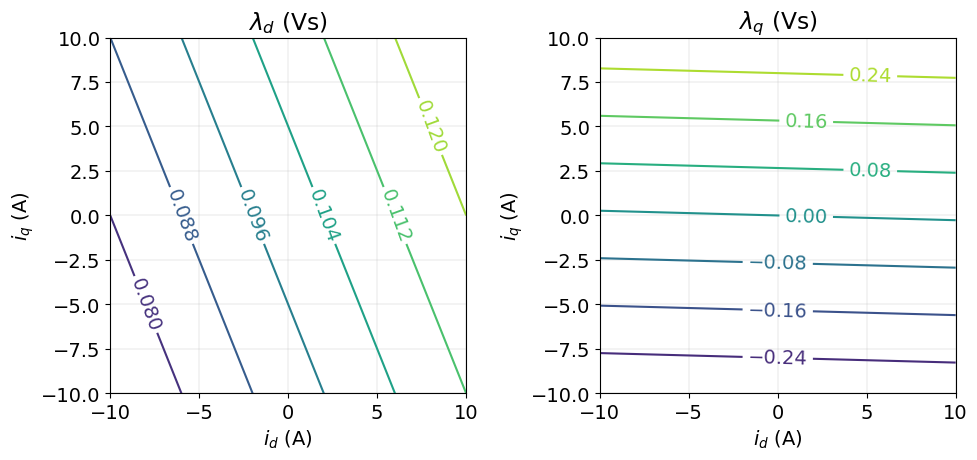

In [41]:
# plot the flux-linkage characteristics (loaded data) - contour plot
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1)
CS = ax.contour(mot.i_d, mot.i_q, mot.lambda_d)
ax.clabel(CS, inline=True)
ax.set_aspect('equal')
plt.xlabel('$i_d$ (A)')
plt.ylabel('$i_q$ (A)')
plt.title('$\lambda_d$ (Vs)')
plt.grid(linewidth=0.2)

ax = fig.add_subplot(1, 2, 2)
CS = ax.contour(mot.i_d, mot.i_q, mot.lambda_q)
ax.clabel(CS, inline=True)
ax.set_aspect('equal')
plt.xlabel('$i_d$ (A)')
plt.ylabel('$i_q$ (A)')
plt.title('$\lambda_q$ (Vs)')
plt.grid(linewidth=0.2)

fig.tight_layout()
plt.show()

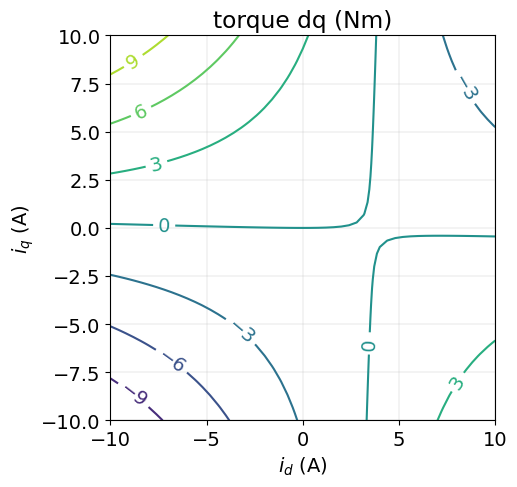

In [42]:
# compute and plot the dq torque
p = 2 # set the number of pole pairs
torque_dq = 3/2 * p * (mot.lambda_d * mot.i_q - mot.lambda_q * mot.i_d)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
CS = ax.contour(mot.i_d, mot.i_q, torque_dq)
ax.clabel(CS, inline=True)
ax.set_aspect('equal')
plt.xlabel('$i_d$ (A)')
plt.ylabel('$i_q$ (A)')
plt.title('torque dq (Nm)')
plt.grid(linewidth=0.2)
plt.show()

computed incremental inductances using gradient
computed MTPA on quadrant 2 using analytical


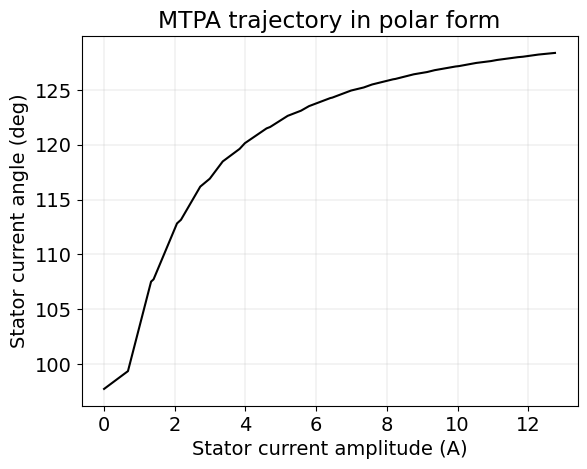

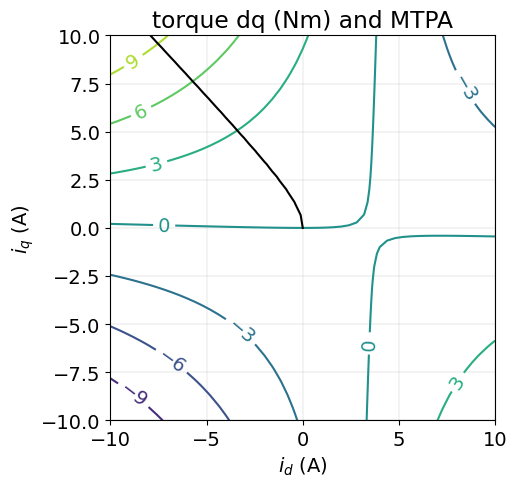

In [43]:
# Compute the MTPA trajectory
mot.calc_incremental_inductances(method = 'gradient')
mot.calc_MTPA(method="analytical", quadrant=2)

plt.plot(mot.i_MTPA, mot.theta_MTPA*180/np.pi, 'k')
plt.xlabel('Stator current amplitude (A)'); plt.ylabel('Stator current angle (deg)')
plt.title('MTPA trajectory in polar form')
plt.grid(linewidth=0.2)
plt.show()

# we can also plot the MTPA trajectory along as the dq torque
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
CS = ax.contour(mot.i_d, mot.i_q, torque_dq)
ax.plot(mot.i_d_MTPA, mot.i_q_MTPA, 'k')
ax.clabel(CS, inline=True)
ax.set_aspect('equal')
plt.xlabel('$i_d$ (A)')
plt.ylabel('$i_q$ (A)')
plt.title('torque dq (Nm) and MTPA')
plt.grid(linewidth=0.2)
plt.show()

computed saliency
computed sensored error using IPM convention
computed sensored trajectory
computed convergence region


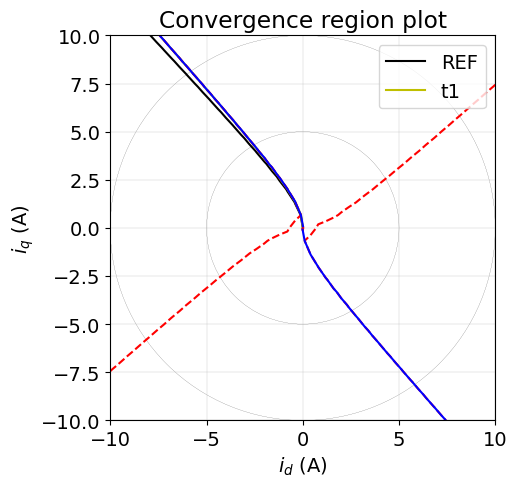

In [44]:
# COMPUTE THE CONVERGENCE REGION USING THE MTPA AS REFERENCE

# compute saliency xi and estimation error epsilon
mot.calc_saliency()
mot.calc_sensored_error()

# set the MTPA as reference trajectory
mot.i_d_REF   = mot.i_d_MTPA
mot.i_q_REF   = mot.i_q_MTPA

# compute sensored trajectory t1
mot.calc_sensored_trajectory()

# compute convergence region
Uh = 40
fh = 1000
mot.calc_convergence_region(Uh, fh)

# plot REF, t1, t2
fig, ax = plt.subplots(figsize=(5,5))
circle5  = plt.Circle((0, 0),  5, fill=False, linewidth=0.1)
circle10 = plt.Circle((0, 0), 10, fill=False, linewidth=0.1)
ax.add_artist(circle5)
ax.add_artist(circle10)
ax.plot(mot.i_d_REF, mot.i_q_REF, 'k', label='REF')
ax.plot(mot.i_d_sensored, mot.i_q_sensored, 'y', label='t1')
ax.contour(mot.i_d, mot.i_q, mot.Ihq, levels=[0], colors='r', linestyles='dashed')
ax.contour(mot.i_d, mot.i_q, mot.Ihq_neg, levels=[0], colors='b')
plt.xlabel('$i_d$ (A)')
plt.ylabel('$i_q$ (A)')
ax.set_aspect('equal')
plt.title('Convergence region plot')
plt.legend(loc="upper right")
plt.grid(linewidth=0.2)
plt.show()
# LEGEND:
# black: reference trajectory REF
# yellow: sensored trajectory t1
# blue: Ihq=0 with negative slope (convergence region)
# red: Ihq=0 with positive slope (no convergence)